In [1]:
import pandas as pd
import datetime as dt
import numpy as np
 

df = pd.read_excel( r"C:\Users\admin\Downloads\sales_data.xlsx" )
df.head()

,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,DAYSSINCELASTORDER,...,WEEK3_DAY16_DAY23_REVENUE,WEEK4_DAY24_DAY31_REVENUE,TIME_0000_0600_ORDERS,TIME_0601_1200_ORDERS,TIME_1200_1800_ORDERS,TIME_1801_2359_ORDERS,TIME_0000_0600_REVENUE,TIME_0601_1200_REVENUE,TIME_1200_1800_REVENUE,TIME_1801_2359_REVENUE
0,22,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,1,...,2592.18,2409.71,12,61,37,14,1067.92,5674.65,3916.53,1327.44
1,29,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,1,...,2807.66,4106.19,1,13,24,44,30.25,3143.69,2205.47,5646.55
2,83,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,1,...,713.94,2861.90,0,6,12,25,0.00,707.98,2560.91,3990.80
3,95,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,1,...,997.02,1260.08,0,10,13,21,0.00,1908.99,2025.05,3058.23
4,124,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,1,...,2725.66,768.46,6,9,27,13,501.34,1197.83,3004.77,1559.50


In [2]:
user = pd.DataFrame(df['CustomerID'].unique())
user.columns = ['CustomerID']
user.head()

,CustomerID
0,22
1,29
2,83
3,95
4,124


In [3]:
#finding Recency value ,days since last order is recency value

user = pd.merge(user, df[['CustomerID','DAYSSINCELASTORDER']], on='CustomerID')
user.head()

,CustomerID,DAYSSINCELASTORDER
0,22,1
1,29,1
2,83,1
3,95,1
4,124,1


In [5]:
user.rename(columns = {'DAYSSINCELASTORDER':'Recency'}, inplace = True)

In [6]:
user.head()

,CustomerID,Recency
0,22,1
1,29,1
2,83,1
3,95,1
4,124,1


In [7]:
#segregrating recency value into 4 clusters 
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
user['RecencyCluster'] = kmeans.fit_predict(user[['Recency']])

In [8]:
user.head()

,CustomerID,Recency,RecencyCluster
0,22,1,0
1,29,1,0
2,83,1,0
3,95,1,0
4,124,1,0


In [9]:
#Ordering clusters We have a cluster corresponding to each customerID. But each cluster is randomly assigned.We will give indices to these clusters as 0,1,2,3. Now we will drop the original cluster numbers and replace them with 0,1,2,3. Code is below.


def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

user = order_cluster('RecencyCluster', 'Recency',user,False)

In [10]:
user.head()

,CustomerID,Recency,RecencyCluster
0,22,1,3
1,29,1,3
2,83,1,3
3,95,1,3
4,124,1,3


In [11]:
#To create frequency clusters, we need to find total number orders for each customer
frequency = df.groupby('CustomerID').TOTAL_ORDERS.count().reset_index()
frequency.columns = ['CustomerID','Frequency']

In [12]:
user = pd.merge(user, frequency, on='CustomerID')

user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,22,1,3,1
1,29,1,3,1
2,83,1,3,1
3,95,1,3,1
4,124,1,3,1


In [13]:
kmeans=KMeans(n_clusters=4)
user['FrequencyCluster']=kmeans.fit_predict(user[['Frequency']])


user = order_cluster('FrequencyCluster', 'Frequency',user, True )

user.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,22,1,3,1,0
1,29,1,3,1,0
2,83,1,3,1,0
3,95,1,3,1,0
4,124,1,3,1,0


In [14]:
#We will calculate revenue for each customer
revenue = df.groupby('CustomerID').REVENUE.sum().reset_index()

In [15]:
user = pd.merge(user, revenue, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,REVENUE
0,22,1,3,1,0,11986.54
1,29,1,3,1,0,11025.96
2,83,1,3,1,0,7259.69
3,95,1,3,1,0,6992.27
4,124,1,3,1,0,6263.44


In [16]:
kmeans = KMeans(n_clusters=4)
user['RevenueCluster'] = kmeans.fit_predict(user[['REVENUE']])


user = order_cluster('RevenueCluster', 'REVENUE',user,True)

In [17]:
#calculate overall score and use mean() to see details
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user.groupby('OverallScore')['Recency','Frequency','REVENUE'].mean()

<ipython-input-17-7462988e7eac>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user.groupby('OverallScore')['Recency','Frequency','REVENUE'].mean()


,Recency,Frequency,REVENUE
OverallScore,,,
0,203.444444,1.0,380.348983
1,139.147664,1.0,1256.854617
2,95.583208,1.0,1872.962429
3,24.076701,1.0,1404.522203
4,22.478680,1.0,3332.653177
5,16.858974,1.0,6622.977821
6,13.727273,1.0,13587.530000


In [18]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value' 

In [19]:
user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,REVENUE,RevenueCluster,OverallScore,Segment
0,22,1,3,1,0,11986.54,3,6,High-Value
1,29,1,3,1,0,11025.96,3,6,High-Value
2,4,5,3,1,0,18554.49,3,6,High-Value
3,17,6,3,1,0,12969.98,3,6,High-Value
4,10,13,3,1,0,14309.92,3,6,High-Value
...,...,...,...,...,...,...,...,...,...
4995,173946,207,0,1,0,117.49,0,0,Low-Value
4996,173987,207,0,1,0,117.49,0,0,Low-Value
4997,174004,207,0,1,0,117.49,0,0,Low-Value
4998,174038,207,0,1,0,117.49,0,0,Low-Value


In [20]:
import plotly.offline as pyo
import plotly.graph_objs as go

In [52]:
graph = user.query("REVENUE < 34000 and Frequency <100")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Frequency'],
        y=graph.query("Segment == 'Low-Value'")['REVENUE'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=graph.query("Segment == 'Mid-Value'")['REVENUE'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Frequency'],
        y=graph.query("Segment == 'High-Value'")['REVENUE'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "REVENUE"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)



In [25]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [36]:
graph = user.query("REVENUE <35000 and Recency<200")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Recency'],
        y=graph.query("Segment == 'Low-Value'")['REVENUE'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Recency'],
        y=graph.query("Segment == 'Mid-Value'")['REVENUE'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Recency'],
        y=graph.query("Segment == 'High-Value'")['REVENUE'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "REVENUE"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [33]:
df['DAYSSINCELASTORDER'].max()

207

In [43]:
graph = user.query("Recency < 200 and Frequency < 200")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Recency'],
        y=graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Recency'],
        y=graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Recency'],
        y=graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)



In [40]:
user['Recency'].max()

207

In [47]:
graph = user.query("REVENUE <35000 and Frequency <200")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Frequency'],
        y=graph.query("Segment == 'Low-Value'")['REVENUE'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=graph.query("Segment == 'Mid-Value'")['REVENUE'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Frequency'],
        y=graph.query("Segment == 'High-Value'")['REVENUE'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "REVENUE"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)



In [ ]:
We can start taking actions with this segmentation. The main strategies are quite clear:

High Value: Improve Retention
Mid Value: Improve Retention + Increase Frequency
Low Value: Increase Frequency+improve retention

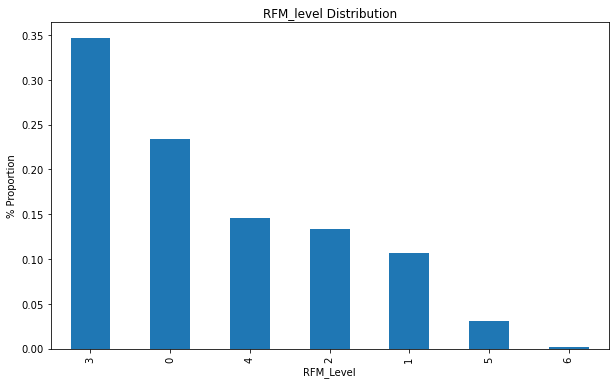

In [48]:
#recency frequency monetary distribution
plt.figure(figsize=(10,6))
user['OverallScore'].value_counts(normalize = True).plot(kind='bar')
plt.title('RFM_level Distribution')
plt.xlabel('RFM_Level')
plt.ylabel('% Proportion')
plt.show()

In [53]:
#days since last order can be calculated by
purchase = df.groupby('CustomerID').LATEST_ORDER_DATE.max().reset_index()
purchase.columns = ['CustomerID','MaxPurchaseDate']
purchase.head()


,CustomerID,MaxPurchaseDate
0,1,2021-09-02
1,2,2021-07-23
2,3,2021-09-02
3,4,2021-10-20
4,5,2021-06-17


In [55]:
purchase['Recency'] = (purchase['MaxPurchaseDate'].max() - purchase['MaxPurchaseDate']).dt.days
purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,1,2021-09-02,52
1,2,2021-07-23,93
2,3,2021-09-02,52
3,4,2021-10-20,4
4,5,2021-06-17,129


In [ ]:
finding recency from above formula and using days since last order column as recency have 1 day difference not making much impact on analysis